#### 2020.05.21

## Image segmentation with IXI - middle slice in the firts dimension (out of plane resolution)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = Path('/data-10tb/marek/IXI/fastai/data2d-sl75')
path.ls()

[PosixPath('/data-10tb/marek/IXI/fastai/data2d-sl75/images'),
 PosixPath('/data-10tb/marek/IXI/fastai/data2d-sl75/labels'),
 PosixPath('/data-10tb/marek/IXI/fastai/data2d-sl75/codes.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:2]

[PosixPath('/data-10tb/marek/IXI/fastai/data2d-sl75/images/IXI225-Guys-0832-T1.anat_T1_biascorr_075.png'),
 PosixPath('/data-10tb/marek/IXI/fastai/data2d-sl75/images/IXI370-Guys-0921-T1.anat_T1_biascorr_075.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:2]

[PosixPath('/data-10tb/marek/IXI/fastai/data2d-sl75/labels/IXI201-HH-1588-T1.anat_T1_biascorr_075_M.png'),
 PosixPath('/data-10tb/marek/IXI/fastai/data2d-sl75/labels/IXI662-Guys-1120-T1.anat_T1_biascorr_075_M.png')]

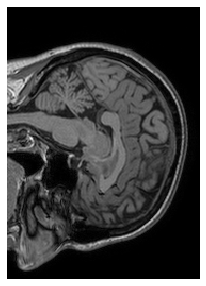

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_M{x.suffix}'

In [9]:
# print(img_f)
# print()
# print(img_f.stem)
# print()
# print(img_f.suffix)
# print()
# get_y_fn(img_f)

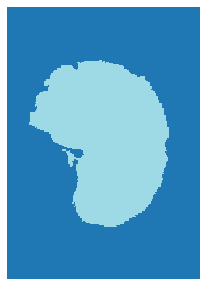

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
print (mask.shape)
print(src_size)
#print(mask.data)

torch.Size([1, 256, 181])
[256 181]


In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['background', 'brain'], dtype='<U10')

In [14]:
len(codes)

2

**WAZNA KOMORKA!!!!!! - ZARZADZANIE PAMIECIA!!!**

In [15]:
#size = src_size//2 # oryg
size = src_size // 2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=16
else:           bs=8
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 9058MB of GPU RAM free


In [16]:
src = (SegmentationItemList.from_folder(path_img) # we jave a list of image files that are in a folder
       .split_by_rand_pct(valid_pct=0.2, seed=42)
       .label_from_func(get_y_fn, classes=codes))  # we need a labels form function we have just 
                                                   # created and a txt file

In [17]:
# we create a data sets

# tfm_y we want to transform mask as well, image oryg (x) and mask (y)
data = (src.transform(get_transforms(), size=size, tfm_y=True) 
        .databunch(bs=bs)
        .normalize(imagenet_stats))

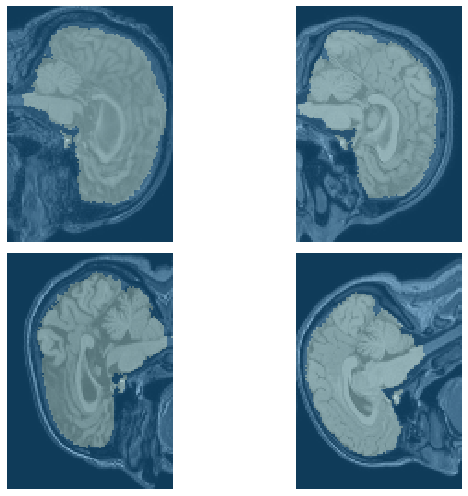

In [18]:
# show_batch combines both images for us, oryginal (x) and mask (y)
data.show_batch(2, figsize=(10,7))

In [19]:
#data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [20]:
wd=1e-2

In [21]:
#torch.cuda.empty_cache()

In [22]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd)

In [23]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.63E-05
Min loss divided by 10: 4.37E-04


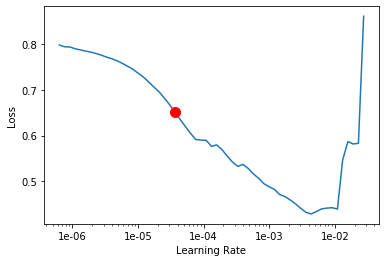

In [38]:
learn.recorder.plot(suggestion=True)

In [24]:
lr=1e-5 # oryginal

In [25]:
#learn.fit_one_cycle(10, slice(lr), pct_start=0.9)
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.923578,0.560498,0.670078,00:04
1,0.564947,0.225118,0.882250,00:03
2,0.361239,0.139783,0.924400,00:03
3,0.259125,0.126826,0.931143,00:03
4,0.204335,0.121341,0.933267,00:03


In [26]:
learn.save('stage-1')

In [27]:
learn.load('stage-1');

In [28]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.139041,0.119993,0.934488,00:03
1,0.130949,0.100955,0.944064,00:03
2,0.122162,0.096925,0.945693,00:03
3,0.117654,0.095405,0.946433,00:03


In [29]:
learn.save('stage-2')

In [35]:
learn.load('stage-2');

In [36]:
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.108256,0.094389,0.947229,00:03
1,0.110358,0.091798,0.948657,00:03
2,0.109742,0.089808,0.948833,00:03
3,0.107126,0.090213,0.948739,00:03
4,0.104049,0.086379,0.951146,00:03
5,0.101020,0.086297,0.950926,00:03
6,0.099510,0.085352,0.952020,00:03
7,0.097006,0.085353,0.951631,00:03


In [37]:
learn.save('stage-3')

In [39]:
learn.load('stage-3');

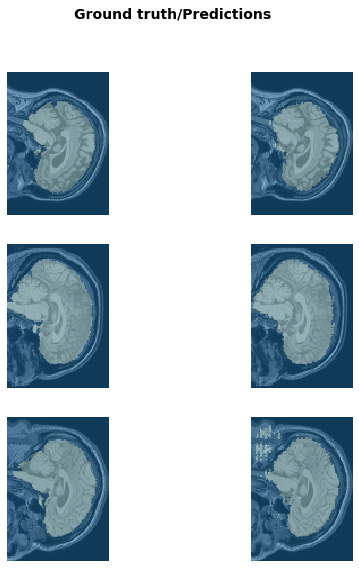

In [40]:
learn.show_results(rows=3, figsize=(8,9))

In [41]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.45E-06


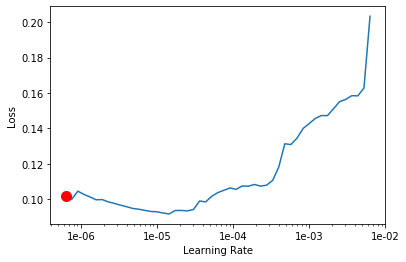

In [42]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [43]:
lrs = slice(1e-6,lr/5)

In [44]:
# learn.fit_one_cycle(10, lrs, pct_start=0.8)
learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,dice,time
0,0.095481,0.085062,0.952015,00:04
1,0.096005,0.084140,0.952245,00:04
2,0.095928,0.083758,0.952666,00:04
3,0.095576,0.083508,0.952413,00:04
4,0.095003,0.084697,0.952328,00:04
5,0.093989,0.082683,0.953061,00:04
6,0.093137,0.081415,0.953870,00:04
7,0.093204,0.083959,0.952871,00:04
8,0.093009,0.082997,0.953154,00:04
9,0.093213,0.082037,0.953598,00:04


In [45]:
learn.save('stage-4');

In [46]:
learn.load('stage-4');

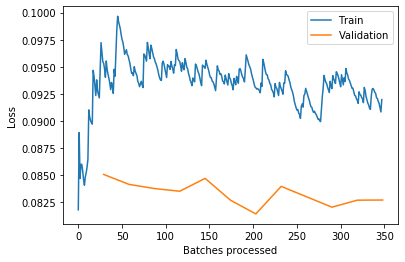

In [47]:
learn.recorder.plot_losses()

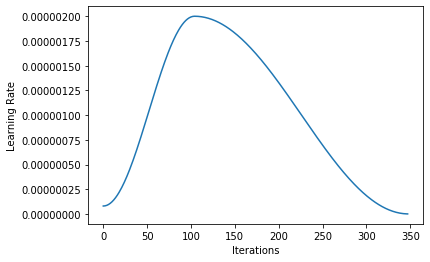

In [48]:
learn.recorder.plot_lr()

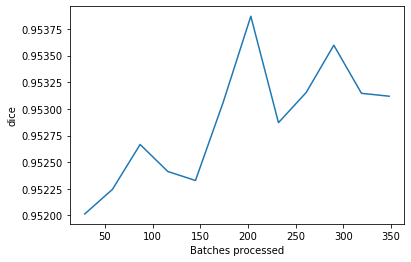

In [49]:
learn.recorder.plot_metrics()